## EDA
### Dataset
Data is taken from here: https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html.

Our target labels are:
1. **Denial of Service (DoS)**: is an attack in which an adversary directed a deluge of traffic requests to a system in order to make the computing or memory resource too busy or too full to handle legitimate requests and in the process, denies legitimate users access to a machine.
2. **Probing Attack (Probe)**: probing network of computers to gather information to be used to compromise its security controls.
3. **User to Root Attack (U2R)**: a class of exploit in which the adversary starts out with access to a normal user account on the system (gained either by sniffing passwords, a dictionary attack, or social engineering) and is able to exploit some vulnerability to gain root access to the system.
4. **Remote to Local Attack (R2L)**: occurs when an attacker who has the ability to send packets to a machine over a network but who does not have an account on that machine exploits some vulnerability to gain local access as a user of that machine.

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import plotly.graph_objs as go

%matplotlib inline

corrected = "./data/corrected"
kddcup_data_corrected = "./data/kddcup.data.corrected"

kddcup_data_10_percent_corrected = "./data/kddcup.data_10_percent_corrected"
kddcup_testdata_10_percent = "./data/kddcup.testdata.unlabeled_10_percent"

correspondence = "./data/training_attack_types.txt"
#header_files = "./data/headers"

In [ ]:
dct = dict()
with open(correspondence, "r") as f:
    for line in f:
        line = line.split()
        if line != []:
            dct[line[0]] = line[1][:-1]
dct["normal"] = "normal"

In [ ]:
'''header_files = "./data/headers"
with open(header_files, 'r') as f:
    header = f.readline().strip().split(',')'''
header=['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
        'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
        'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
        'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
        'num_access_files', 'num_outbound_cmds', 'is_host_login',
        'is_guest_login', 'count', 'srv_count', 'serror_rate',
        'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
        'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
        'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
        'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
        'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
        'dst_host_srv_rerror_rate', 'classes']

In [ ]:
print(header)

In [ ]:
df = pd.read_csv(kddcup_data_10_percent_corrected, header=None)
df.columns = header
df.head()

In [ ]:
df.classes.value_counts()

In [ ]:
test_data = pd.read_csv(kddcup_testdata_10_percent, header=None)
test_data.columns = header[:-1]

In [ ]:
def labels_map(label):
    """
     0 - normal
     1 - probe -  surveillance and other probing, e.g., port scanning.
     2 - dos - denial-of-service, e.g. syn flood;
     3 - u2r - unauthorized access to local superuser (root) privileges, e.g., various __buffer overflow__ attacks;
     4 - R2L - unauthorized access from a remote machine, e.g. guessing password;
    """
    label = str(label).split('.')[0]
    if label == 'normal':
        return 0
    if label in ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']:
        return 1
    if label in ['apache2', 'back', 'land', 'mailbomb', 'neptune', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm']:
        return 2
    if label in ['buffer_overflow', 'httptunnel', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']:
        return 3
    if label in ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack',
                 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'worm', 'xlock', 'xsnoop']:
        return 4
df['classes'] = df.classes.apply(labels_map)
test_data.classes = test_data.apply(labels_map)

In [ ]:
df.classes.value_counts()

**Percentage distribution of class labels in dataset**

In [ ]:
rows_count = df.shape[0]
df.groupby('classes').size() * 100/rows_count

In [ ]:
df.groupby(['protocol_type'])['classes'].value_counts()

In [ ]:
df.groupby(['classes'])['service'].value_counts()

In [ ]:
X = df[df.columns[:-1]]

In [ ]:
print('The number of duplicates is {}\n'.format(X.duplicated().sum()))
print('The total numer of rows is {}'.format(X.shape[0]))

In [ ]:
print('The number of duplicates in test is {}\n'.format(test_data.duplicated().sum()))
print('The total numer of rows in test is {}'.format(test_data.shape[0]))

In [ ]:
categorial_features = ['protocol_type','service','flag','land','logged_in','is_host_login','is_guest_login']
x_categor = X.loc[:,categorial_features]

In [ ]:
sns.countplot(x_categor.flag)

Can someone attack a guest profile?

In [ ]:
sns.countplot(df[(df['is_guest_login'] == 1)].classes)

In [ ]:
sns.countplot(x_categor['is_guest_login'])

Is everybody logged

In [ ]:
sns.countplot(x_categor['logged_in'])

In connection with a large number of duplicate data, we delete them.
Remove duplicate rows

In [ ]:
print('rows and columns: ' + str(df.shape))
df = df.drop_duplicates()
print('rows and columns after removing duplicates:' + str(df.shape))

The numbers of none values

In [ ]:
len(df[df.isnull().any(axis=1)])

Let's try to find unnecessery columns. Features which will not impact on our prediction.

In [ ]:
for col in np.array(df.columns):
    if len(df[col].unique()) == 1:
        print(col)

In [ ]:
df.num_outbound_cmds.unique()

This feature has the same value in all samples.

In [ ]:
df.drop('num_outbound_cmds', axis=1,inplace=True)

### Let's see to the numerical features

In [ ]:
cols=list(df.axes[1].values)
x_numerical=df.loc[:,list(set(cols).difference(set(categorial_features)))]

In [ ]:
x_numerical.describe()

In [ ]:
corr = x_numerical.corr()
f, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
pairsSet = set()

def is_only_zero_and_one(array):
    array = np.array(array.unique())
    return len(array) == 2 and ((array[0] == 0 and array[1] == 1) or ((array[0] == 1 and array[1] == 0)))

for column in x_numerical.columns:
    for inner_column in x_numerical.columns:
        key1 = column + '-' + inner_column
        key2 = inner_column + '-' + column
        if column != inner_column and key1 not in pairsSet and key2 not in pairsSet:
            pairsSet.add(key1)
            pairsSet.add(key2)
            correlation = np.corrcoef(x_numerical[column], x_numerical[inner_column])[0, 1]
            if ((correlation >= 0.75) &  (not is_only_zero_and_one(x_numerical[column])) &  (not is_only_zero_and_one(x_numerical[inner_column]))):
                print(column + " -- " + inner_column)
                print(correlation)


In [ ]:
print(df.serror_rate.describe())
print(df.dst_host_srv_serror_rate.describe())
print(df.srv_serror_rate.describe())
print(df.dst_host_serror_rate.describe())
print(df.num_root.describe())
print(df.num_compromised.describe())

We should remove unecessery information

In [ ]:
corr_column_names = ['dst_host_srv_serror_rate', 'srv_serror_rate', 'dst_host_serror_rate']
df.drop(corr_column_names, axis=1, inplace=True)

In [ ]:
sns.distplot(x_numerical['num_root'])

### Translate categorial data to numeric

In [ ]:
le = LabelEncoder()
need_labeling = ['protocol_type', 'service','flag']

for i in need_labeling:
    le.fit(df[i])
    df[i] = le.transform(df[i])

### **Feature selection using random forest **

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth=25, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
X = df[df.columns[:-1]]
y = df['classes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23, random_state=42)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
def do_normalization(x_train):
    cat_features = ['protocol_type','service','flag','land','logged_in','is_host_login','is_guest_login']
    cols=list(x_train.axes[1].values)
    cont_features=list(set(cols).difference(set(cat_features)))
    scaler = MinMaxScaler()
    x_train.loc[:,cont_features]=scaler.fit_transform(x_train.loc[:,cont_features])
    return x_train
X_train = do_normalization(X_train)
X_test = do_normalization(X_test)

In [ ]:
X_train.head()

In [ ]:
rf.fit(X_train,y_train)

In [ ]:
importances=[]
for (x,y) in zip((X_train.axes[1].values),rf.feature_importances_):
    importances.append([x, y])

print([i[0] for i in importances])

In [ ]:
fig, axes = plt.subplots(figsize=(20,10))
sns.barplot(x=np.sort([i[1] for i in importances]),y=[i[0] for i in importances])

### Save data

In [ ]:
X_train.to_csv("./data/train_data")
y_train.to_csv("./data/train_labels")
X_test.to_csv("./data/test_data")
y_test.to_csv("./data/test_labels")
y_train=y_train[~y_train[1].isin(['classes'])]
y_test=y_test[~y_test[1].isin(['classes'])]

## Results of EDA

1. We find 1 feature that doesn't impact on target
2. 3 feature we've deleted due to high correlation
3. Many samples had duplicate.
4. It seems that some of features are not important

In [13]:
import pandas as pd
from sklearn import ensemble, metrics, neighbors, manifold
import gc
import pylab
%pylab inline

Populating the interactive namespace from numpy and matplotlib


d:\anaconda3\envs\tf1\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
import pandas as pd
X_test = pd.read_csv('data/test_data', header=0, index_col=0)
X_train = pd.read_csv("data/train_data", header=0, index_col=0)
y_train = pd.read_csv("data/train_labels", header=None, index_col=0)
y_test = pd.read_csv('data/test_labels', header=None, index_col=0)

In [15]:
print(X_test.shape)
print(y_test.shape)

(33485, 37)
(33486, 1)


In [16]:
y_train.value_counts()

1      
0          67651
2          41973
1           1632
4            799
3             45
classes        1
dtype: int64

In [17]:
y_test.value_counts()


1      
0          20181
2          12599
1            498
4            200
3              7
classes        1
dtype: int64

In [18]:

num_dots = 15000

arr = [X_test, y_test]
df = pd.concat(arr, axis = 1)

In [19]:
num4_dots = y_test.value_counts()[4]
num3_dots = y_test.value_counts()[3]
num2_dots = (num_dots - num4_dots - num3_dots) // 3
num1_dots = (num_dots - num4_dots - num3_dots) // 3
num0_dots = (num_dots - num4_dots - num3_dots) // 3


columns = list(df.columns)
columns[-1] = 'class'
df.columns = columns

In [20]:
print(df['class'].value_counts())

0          20181
2          12599
1            498
4            200
3              7
classes        1
Name: class, dtype: int64


In [21]:
df0 = df.loc[df['class']=='0'].iloc[:num0_dots]
df1 = df.loc[df['class']=='1'].iloc[:num1_dots]
df2 = df.loc[df['class']=='2'].iloc[:num2_dots]
df3 = df.loc[df['class']=='3'].iloc[:num3_dots]
df4 = df.loc[df['class']=='4'].iloc[:num4_dots]

In [22]:
arr = [df0, df1, df2, df3, df4]

vis_df = pd.concat(arr, axis=0)

del df0
del df1
del df2
del df3
del df4

gc.collect()

from sklearn.utils import shuffle
vis_df = shuffle(vis_df)

print (vis_df.shape)

vis_labels = pd.DataFrame(data = vis_df['class'] )
vis_labels.head(5)
vis_df.drop('class', axis=1, inplace=True)

(10374, 38)


In [23]:
%time

Wall time: 0 ns


In [24]:
tsne = manifold.TSNE(n_components=2, init='pca')
data_2d_tsne = tsne.fit_transform(vis_df)
labels = np.reshape(vis_labels.values, (vis_labels.shape[0]))

Exception in Tkinter callback
Traceback (most recent call last):
  File "d:\anaconda3\envs\tf1\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "d:\anaconda3\envs\tf1\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "d:\anaconda3\envs\tf1\lib\site-packages\matplotlib\backends\_backend_tk.py", line 253, in idle_draw
    self.draw()
  File "d:\anaconda3\envs\tf1\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "d:\anaconda3\envs\tf1\lib\site-packages\matplotlib\backends\backend_agg.py", line 407, in draw
    self.figure.draw(self.renderer)
  File "d:\anaconda3\envs\tf1\lib\site-packages\matplotlib\backend_bases.py", line 1544, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x0000019E9042D5C0>
Exception in Tkinter callback
Traceback (most recent ca

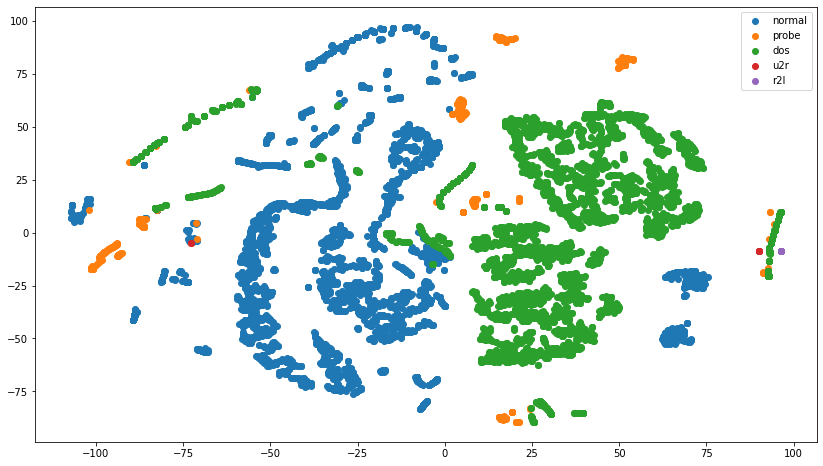

In [32]:
pylab.figure(figsize = (14, 8))
name = ['normal', 'probe', 'dos', 'u2r', 'r2l']
for label in ['0', '1', '2', '3', '4']:
    a = [labels == label]
    pylab.scatter(data_2d_tsne[np.where(a[0])[0], 0], data_2d_tsne[np.where(a[0])[0], 1],label = name[int(label)])
pylab.legend()
pylab.show()

In [26]:
%time
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_2d_pca = pca.fit_transform(vis_df)


Wall time: 0 ns


Exception in Tkinter callback
Traceback (most recent call last):
  File "d:\anaconda3\envs\tf1\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "d:\anaconda3\envs\tf1\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "d:\anaconda3\envs\tf1\lib\site-packages\matplotlib\backends\_backend_tk.py", line 253, in idle_draw
    self.draw()
  File "d:\anaconda3\envs\tf1\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "d:\anaconda3\envs\tf1\lib\site-packages\matplotlib\backends\backend_agg.py", line 407, in draw
    self.figure.draw(self.renderer)
  File "d:\anaconda3\envs\tf1\lib\site-packages\matplotlib\backend_bases.py", line 1544, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x0000019E89A797F0>
Exception in Tkinter callback
Traceback (most recent ca

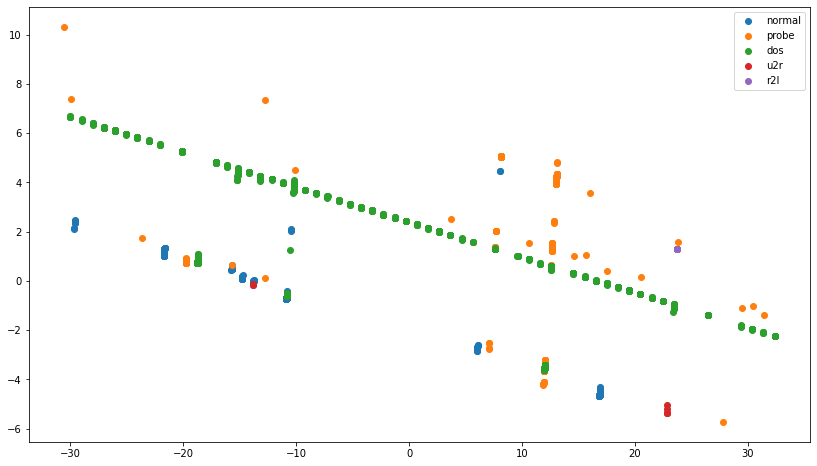

In [33]:
labels = np.reshape(vis_labels.values, (vis_labels.shape[0]))
pylab.figure(figsize = (14, 8))
name = ['normal', 'probe', 'dos', 'u2r', 'r2l']
for label in ['0', '1', '2', '3', '4']:
    a = [labels == label]
    pylab.scatter(data_2d_pca[np.where(a[0])[0], 0], data_2d_pca[np.where(a[0])[0], 1],label = name[int(label)])
pylab.legend()
pylab.show()

In [34]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, accuracy_score, classification_report

In [35]:
f1 = make_scorer(f1_score, 'macro')

In [59]:
params = {
    'max_depth' : [3,5,10],
    'learning_rate' : [0.01,.05,.1],
    'n_estimators' :[100,150,200],
    'gamma' : [0,0.1],
    'reg_lambda' : [1,2]
}

clf = GridSearchCV(XGBClassifier(), params, verbose=1)
clf.fit(X_train.head(1000), y_train.head(1000),eval_metric = "merror")

print (clf.best_estimator_)
clf = clf.best_estimator_

print (f1_score(y_train, clf.predict(X_train),labels=[0,1,2,3,4], average='macro'))
print (accuracy_score(y_train, clf.predict(X_train)))
print (f1_score(y_test, clf.predict(X_test), labels=[0,1,2,3,4], average='macro'))
print (accuracy_score(y_test, clf.predict(X_test)))

d:\anaconda3\envs\tf1\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
d:\anaconda3\envs\tf1\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
d:\anaconda3\envs\tf1\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

Fitting 3 folds for each of 108 candidates, totalling 324 fits
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)
0.7370918269320458
0.9933898305084746
0.6493366049288078
0.9798417201732119


In [61]:
clf = XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=150, gamma=0, reg_lambda=2)
clf.fit(X_train,y_train,eval_metric = "merror")

predict = clf.predict(X_test)


print (classification_report(y_test, predict, digits=2))

d:\anaconda3\envs\tf1\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
d:\anaconda3\envs\tf1\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\anaconda3\envs\tf1\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.99      0.92      0.95     20181
           1       1.00      0.54      0.70       498
           2       0.87      1.00      0.93     12599
           3       0.80      0.57      0.67         7
           4       0.94      0.72      0.82       200

    accuracy                           0.94     33485
   macro avg       0.92      0.75      0.82     33485
weighted avg       0.95      0.94      0.94     33485



In [62]:
target_names = ['normal', 'probing', 'dos','u2r' ,'r2l']
print (classification_report(y_test, predict, digits=4, target_names=target_names))

              precision    recall  f1-score   support

      normal     0.9934    0.9183    0.9544     20181
     probing     0.9963    0.5422    0.7022       498
         dos     0.8747    0.9998    0.9331     12599
         u2r     0.8000    0.5714    0.6667         7
         r2l     0.9416    0.7250    0.8192       200

    accuracy                         0.9421     33485
   macro avg     0.9212    0.7513    0.8151     33485
weighted avg     0.9484    0.9421    0.9417     33485

